In [6]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer

In [7]:
df = pd.read_excel("data.xlsx")

In [8]:
# Feature Engineering
df['hour'] = df['Date/Time'].dt.hour
df['day_of_week'] = df['Date/Time'].dt.dayofweek
df["month"] = df["Date/Time"]
# add other features...

# Model Selection
X = df[['Wind', 'Solar', 'AEP Load', 'ATSI Load', 'COMED Load',
        'DOM Load', 'hour', 'day_of_week']]  # predictors
y_DA = df['Constraint DA']  # target
y_RT = df['Constraint RT']  # target

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_DA, test_size=0.2, random_state=42)


In [10]:
# Use a median imputer
imputer = SimpleImputer(strategy='mean')

# Train the imputer (this computes the median for each column)
imputer.fit(X_train)

# Transform the data (this replaces missing values with the medians)
X_train_imputed = imputer.transform(X_train)
X_test_imputed = imputer.transform(X_test)

In [21]:
# Create an XGBoost model
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1, seed=123)

# Fit the model
xgb_reg.fit(X_train_imputed, y_train)

# Make predictions
y_pred_xgb = xgb_reg.predict(X_test_imputed)

# Compute RMSE
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print("RMSE: %f" % (rmse_xgb))


RMSE: 95.143577


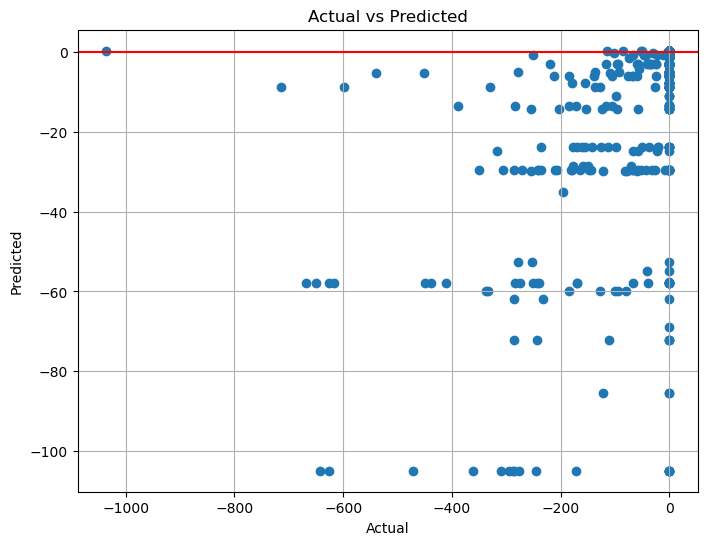

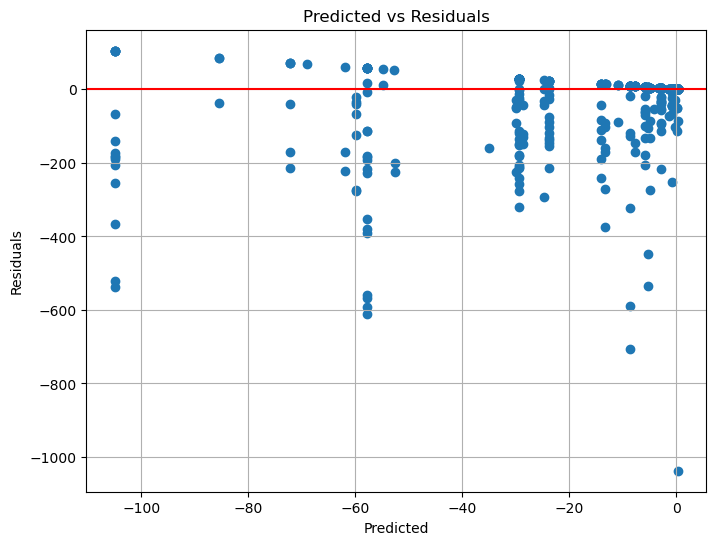

In [22]:
# Plot actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_xgb)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Actual vs Predicted')
plt.grid(True)
plt.show()

# Plot residuals
residuals = y_test - y_pred_xgb
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_xgb, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Predicted vs Residuals')
plt.grid(True)
plt.show()


# ARIMA

In [24]:
df

,Date/Time,Constraint DA,Constraint RT,Wind,Solar,AEP Load,ATSI Load,COMED Load,DOM Load,hour,day_of_week
0,2021-07-01 01:00:00,0.0,0.0,753.281,0.0,14236,7455,11651,14123,1,3
1,2021-07-01 02:00:00,0.0,0.0,738.755,0.0,13636,7091,10871,13345,2,3
2,2021-07-01 03:00:00,0.0,0.0,724.276,0.0,13171,6850,10313,12765,3,3
3,2021-07-01 04:00:00,0.0,0.0,752.041,0.0,12962,6714,9925,12393,4,3
4,2021-07-01 05:00:00,0.0,0.0,759.611,0.0,13060,6730,9731,12293,5,3
...,...,...,...,...,...,...,...,...,...,...,...
4412,2021-12-31 20:00:00,0.0,0.0,3327.337,0.0,13549,7346,10776,11545,20,4
4413,2021-12-31 21:00:00,0.0,0.0,3330.132,0.0,13294,7164,10616,11251,21,4
4414,2021-12-31 22:00:00,0.0,0.0,3343.444,0.0,12985,6948,10420,10863,22,4
4415,2021-12-31 23:00:00,0.0,0.0,3418.329,0.0,12579,6669,10155,10329,23,4


In [29]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd

# Assume that 'DA' is your target variable and df is your DataFrame
DA_series = pd.Series(df['Constraint DA'].values, index=df['Date/Time'])

# (p,d,q) parameters of the ARIMA model
model = ARIMA(DA_series, order=(5, 1, 0))
model_fit = model.fit()

# summary of fit model
model_fit.summary()


c:\Users\William Hazen\anaconda3\envs\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\William Hazen\anaconda3\envs\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\William Hazen\anaconda3\envs\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\William Hazen\anaconda3\envs\venv\lib\site-packages\statsmodels\tsa\stattools.py:1346: RuntimeWarning: divide by zero encountered in divide
  test_statistic = numer_squared_sum /

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4417
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -22148.988
Date:                Wed, 12 Jul 2023   AIC                          44309.976
Time:                        15:35:21   BIC                          44348.334
Sample:                             0   HQIC                         44323.505
                               - 4417                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2759      0.003     79.816      0.000       0.269       0.283
ar.L2         -0.1189      0.004    -31.788      0.000      -0.126      -0.112
ar.L3         -0.1035      0.006    -18.084      0.000      -0.115      -0.092
ar.L4         -0.0140      0.008     -1.745      0.081      -0.030       0.002
ar.L5         -0.0358      0.008     -4.225      0.000      -0.052      -0.019
sigma2      1332.0356      5.574    238.975      0.000    1321.111    1342.960
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):            635384.43
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):                inf   Skew:                            -0.44
Prob(H) (two-sided):                  0.00   Kurtosis:                        61.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""